# Pricing equity index options in Euro
In this notebook I price equity index options using volatility tracking, riskless zero rate curve construction, and options pricing code from this package. I ensure that all market and economic data required for pricing is obtained from [FRED](https://fred.stlouisfed.org), [Eurostat](https://ec.europa.eu/eurostat/data/database), and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/). Since the lifetime of an option is usually measured using trading days rather than calendar days, I make use of [the pandas-market-calendars library](https://pandas-market-calendars.readthedocs.io/en/latest/index.html) to get correct trading calendars.

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/options-pricing.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader, eurostat, yfinance
# !pip install pandas-datareader -U
# !pip install sdmx1 -U
# !pip install yfinance -U
# !pip install pandas-market-calendars -U

## Constructing a riskless zero rate curve for Euro
Since I already covered it in a separate notebook, I will simply import it (along with all imports that this notebook needs). The resultant YieldCurve object is
assigned to the `curve` variable

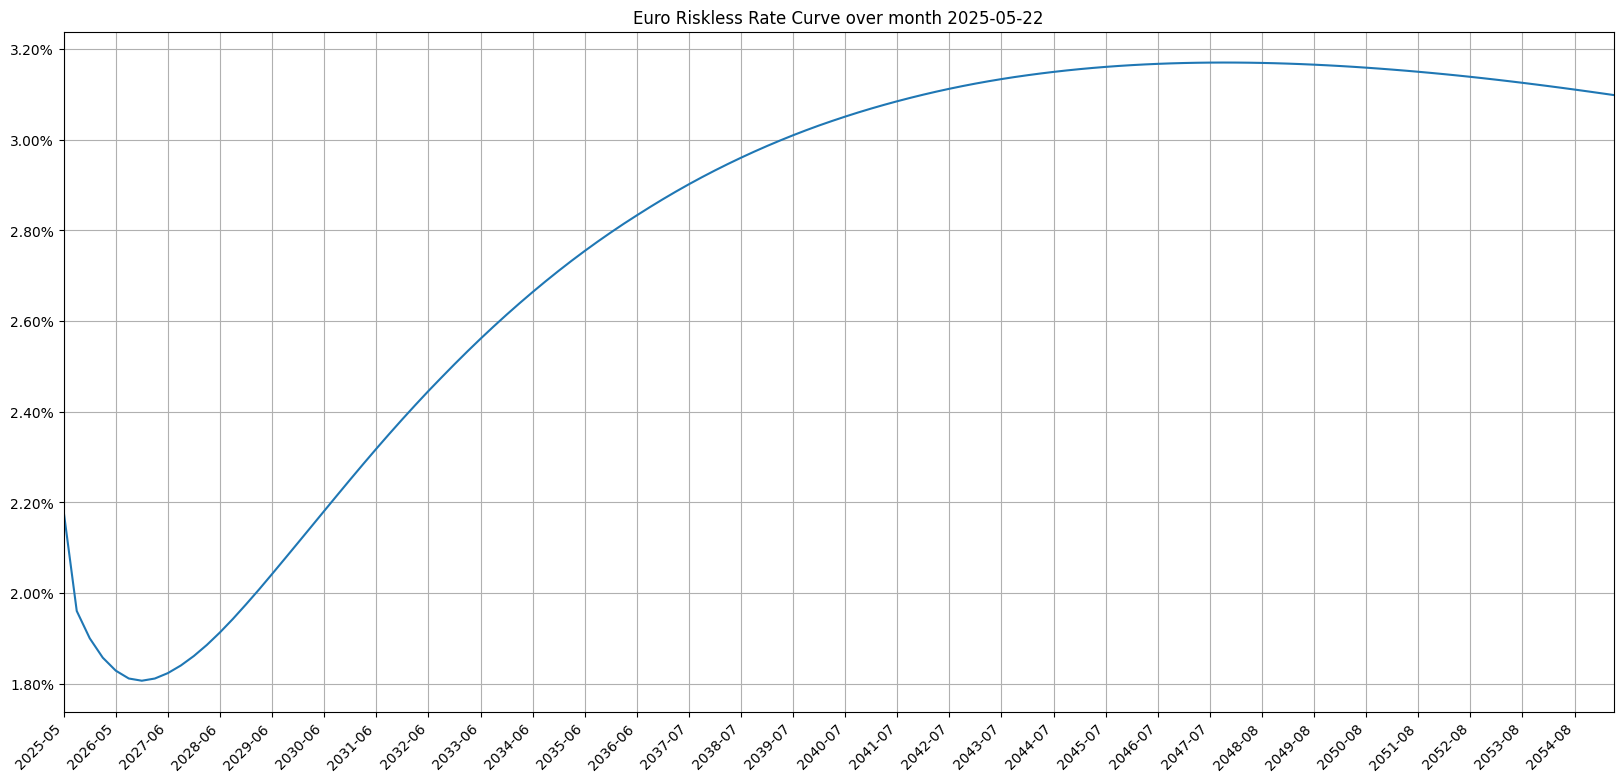

In [2]:
%run euro-riskless-rate-curve-construction-example.ipynb

## Estimating and forecasting volatility of the index, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain an accurate volatility estimate for the index whose options we want to price. There are various methods for doing it. The most common are the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In order to use GARCH(1, 1) one first needs to estimate its parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html) to optimize for maximum likelihood. Alternatively I could've used Google's TensorFlow 2.x.

Constraint optimization for three variables is not fast. If you are not content with the speed of `volatility.parameter_estimators.GARCHParameterEstimator`, you can use its `volatility.parameter_estimators.GARCHVarianceTargetingParameterEstimator` counterpart. This latter class is 
faster because it uses the so-called _variance targeting_ method whereby it sets ω based on the sample variance of price changes. Then it optimises for only two variables instead of three as GARCHParameterEstimator does. It's marginally less accurate.

*NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the `Adj Close` column.

#### Estimating GARCH(1, 1) parameters for AEX (^AEX)
The AEX index is a capitalization-weighted index composed of 25 large capitalization Dutch companies. Since volatility tends to change with time, it's recommended to estimate it based on the most recent 90 or 180 days, or on the same number of days as the duration of the option being priced. In this notebook I use date from the past two years.

In [3]:
TICKER = '^AEX'

# I'll use price changes over the past two years to estimate GARCH(1, 1) ω, α, and β parameters
start = BDay(1).rollback(date.today() - relativedelta(years=+2))
data = yfin.Ticker(TICKER).history(start=start, end=today, actions=False, auto_adjust=False)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

Objective function: 4434.73485 after 110 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000023476278, α=0.19515, β=0.42625


##### Optional: Estimating with a faster estimator &mdash; GARCHVarianceTargetingParameterEstimator

In [4]:
var_target_vol_estimator = parameter_estimators.GARCHVarianceTargetingParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (var_target_vol_estimator.omega, var_target_vol_estimator.alpha, var_target_vol_estimator.beta))

Objective function: 4433.71428 after 41 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000023618189, α=0.23086, β=0.42907


As you can see, `GARCHParameterEstimator` is able to achieve a slightly higher value of the objective function than `GARCHVarianceTargetingParameterEstimator`. The higher, the more accurate as we are solving for the maximum value.

#### Forecasting volatility for AEX
Now that we have obtained the optimal GARCH(1, 1) parameters values&mdash;ω, α, and β&mdash;we can proceed to forecast AEX volatility. I have created the `volatility.parameter_estimators.GARCHVolatilityTracker` class to assist with this.

In [5]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecast for next June options, i.e. maturity on the 3rd Friday of next June
from dateutil.relativedelta import FR
maturity_date = curve.date + relativedelta(years=0 if curve.date.month < 6 else 1, month=6, day=1, weekday=FR(3))
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of ^AEX for term 0.0685 years: 0.12546


#### Optional: Visualizing volatility term structure of the AEX index over the next 5 years
In contrast to the `equity-options-pricing-example.ipynb` notebook where I visualized historical, and future volatilities, in this notebook I'll visualize the volatility term structure for AEX, i.e. forecast average volatility for a certain future term expressed in years.

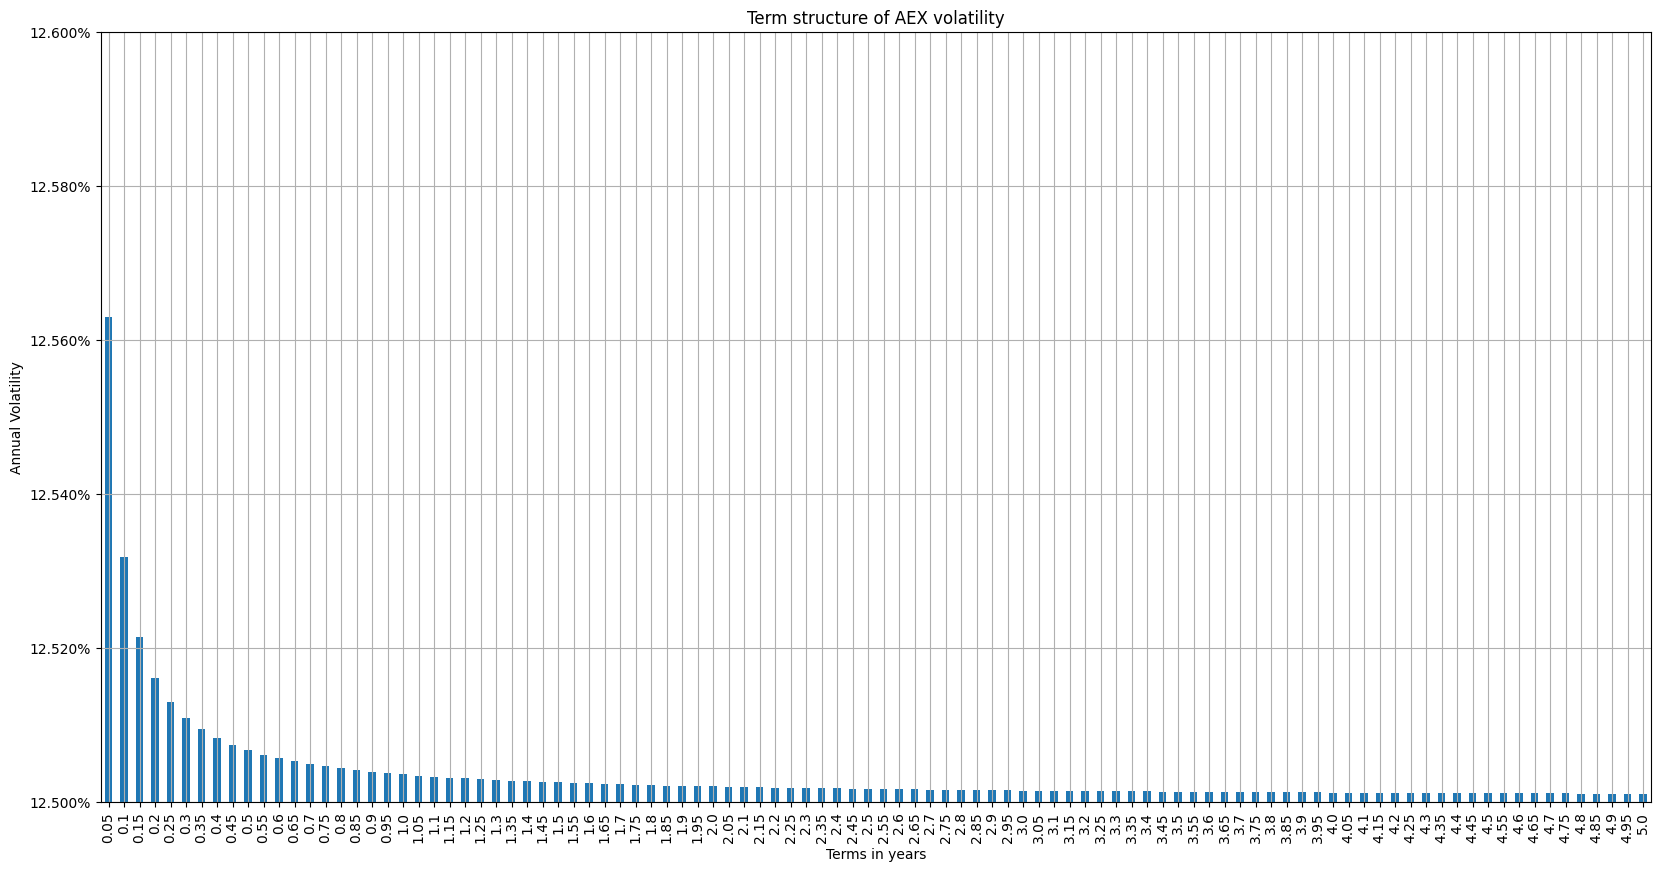

In [6]:
from math import floor, ceil

terms = [x / 100 for x in range(5, 505, 5)]
term_vols = [vol_tracker.get_annual_term_volatility_forecast(term) * 100 for term in terms]
series = pd.Series(term_vols, index=terms)

ax = series.plot(figsize=(20,10), grid=True, kind='bar', title='Term structure of AEX volatility')
ax.set_ylim(bottom=floor(series.min()*10) / 10, top=ceil(series.max()*10) / 10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('Annual Volatility')
_ = ax.set_xlabel('Terms in years')

## Pricing using Black-Scholes-Merton Pricer
The Black-Scholes-Merton model can be used to price European options, including equity indices. With enough customizations it can also be used to price American call options (even those paying dividends or having a known
dividend yield). Exchange and over-the-counter traded equity index options tend to be European.

Let's put it to use to price an AEX call and put options with a strike of 700. Some of the stocks comprising AEX pay dividends. It's essential to take into account the expected dividend yield of AEX to achieve accurate pricing. 

In [7]:
strike = 700.

# Expected AEX dividend yield
q = .0239

cur_price = asset_prices.iloc[-1]
pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                          ticker=TICKER, q=q)
print(pricer)

put_pricer = options.BlackScholesMertonPricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q)
print(put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2025-06-20, price: 216.89, σ: 0.1255, Δ: 0.998, Γ: 0.000, ν: 0.000
^AEX EUROPEAN put option with strike 700.0 and maturity 2025-06-20, price: 0.00, σ: 0.1255, Δ: -0.000, Γ: 0.000, ν: 0.000


Sometimes you might want to price using _an implied volatility_ for the expiry date, implied volatilities are volatilities implied by option prices of market makers. You can easily use implied volatilities with 
the `BlackScholesMertonPricer` class, just pass the volatility value as the second parameter instead of
a volatility tracker:

In [8]:
impl_vol = .24

pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price,
                                          ticker=TICKER, q=q)
print(pricer)

put_pricer = options.BlackScholesMertonPricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                              ticker=TICKER, q=q)
print(put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2025-06-20, price: 216.89, σ: 0.2400, Δ: 0.998, Γ: 0.000, ν: 0.008
^AEX EUROPEAN put option with strike 700.0 and maturity 2025-06-20, price: 0.00, σ: 0.2400, Δ: -0.000, Γ: 0.000, ν: 0.008


#### Put-Call Parity
An important theoretical property of the price of a European option is the so-called put-call parity, which is expressed as:
$$c - p = S_0\cdot e^{-q\cdot T} - K\cdot e^{-r\cdot T}$$
where:
* c is the price of a European call option
* p is the price of the corresponding European put option
* S<sub>0</sub> is the present price of the underlying stock
* q is the expected dividend yield of the index
* K is the strike price
* T is the liefteime of the option expressed in years
* r is the riskless rate for maturity T

Let's put it to the test:

In [9]:
from math import exp
price_difference = pricer.get_price() - put_pricer.get_price()

right_hand_side_expr = pricer.s0 * exp(-pricer.q * pricer.T) - pricer.strike * exp(-pricer.r * pricer.T)

assert np.allclose(price_difference, right_hand_side_expr, .1)
print(f'Put-Call parity: {price_difference:.4f} = {right_hand_side_expr:.4f}')

Put-Call parity: 216.8873 = 216.8873


## Pricing using Binomial Tree Pricer
The Binomial Tree model can be used to price any European or American option, including on index some of whose constituent stocks pay dividends.

Let's put it to use to price an AEX call and put option with a strike of 700 and compare resulting prices with those obtained from the BlackScholesMertonPricer.

In [10]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: %.6f'
      % abs(pricer.get_price() - bin_tree_pricer.get_price()))
bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, impl_vol, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)

print('Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: %.6f'
      % abs(put_pricer.get_price() - bin_tree_put_pricer.get_price()))

^AEX EUROPEAN call option with strike 700.0 and maturity 2025-06-20, price: 216.89, σ: 0.2400, Δ: 0.998, Γ: 0.000, ν: 0.005
Price difference between Black-Scholes-Merton and Binomial Treee pricers for calls: 0.000961
^AEX EUROPEAN put option with strike 700.0 and maturity 2025-06-20, price: 0.00, σ: 0.2400, Δ: -0.000, Γ: 0.000, ν: 0.005
Price difference between Black-Scholes-Merton and Binomial Treee pricers for puts: 0.000079


Now pricing with our volatility forecast:

In [11]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve, cur_price, is_call=False,
                                                 ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2025-06-20, price: 216.89, σ: 0.1255, Δ: 0.998, Γ: -0.000, ν: -0.000
^AEX EUROPEAN put option with strike 700.0 and maturity 2025-06-20, price: 0.00, σ: 0.1255, Δ: 0.000, Γ: 0.000, ν: 0.000


Let's see if the put-call parity holds when pricing with `BinomialTreePricer`

In [12]:
price_difference = bin_tree_pricer.get_price() - bin_tree_put_pricer.get_price()

right_hand_side_expr = bin_tree_pricer.s0 * exp(-bin_tree_pricer.q * bin_tree_pricer.T)\
    - bin_tree_pricer.strike * exp(-bin_tree_pricer.r * bin_tree_pricer.T)

assert np.allclose(price_difference, right_hand_side_expr, .1)
print(f'Put-Call parity: {price_difference:.4f} = {right_hand_side_expr:.4f}')

Put-Call parity: 216.8884 = 216.8873


It does, but not pricing with a given closed formula as is the case for the `BlackScholesMertonPricer` gave rise to
a small difference.

## Pricing with your own discount curve
You might want to prefer to price using your own discount curve. The `YieldCurve` class of the `pricing.curves` package makes it fairly easy to do.

The `parallel_shift` method of the `YieldCurve` class allows for pricing using a parallel shift to the yield curve. Let's price the same options but with a curve points shifted down by 200bps. As expected, this makes calls cheaper and puts more expensive.

In [13]:
bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve.parallel_shift(-200),
                                            cur_price, ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, curve.parallel_shift(-200),
                                                 cur_price, is_call=False, ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2025-06-20, price: 215.93, σ: 0.1255, Δ: 0.998, Γ: -0.000, ν: -0.000
^AEX EUROPEAN put option with strike 700.0 and maturity 2025-06-20, price: 0.00, σ: 0.1255, Δ: 0.000, Γ: 0.000, ν: 0.000


Let's now price with a flat discount curve, which I'll construct by reusing the offsets from earlier in this notebook:

In [14]:
# Reusing 'relativedelta' offsets defined in Cell 3, which are for 0, 1 month, 3 months, 6 months, 1 year, 2 years,
# 3 years, 5 years, 7 years, 10 years, 20 years, 30 years.\n",

# Defining a flat curve with a discount rate of 2% and yearly compounding frequency.
custom_curve = curves.YieldCurve(today, offsets, [.02]*len(offsets), compounding_freq=1)

bin_tree_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, custom_curve, cur_price,
                                             ticker=TICKER, q=q)
print(bin_tree_pricer)

bin_tree_put_pricer = options.BinomialTreePricer(maturity_date, vol_tracker, strike, custom_curve, cur_price,
                                                 is_call=False, ticker=TICKER, q=q)
print(bin_tree_put_pricer)

^AEX EUROPEAN call option with strike 700.0 and maturity 2025-06-20, price: 216.84, σ: 0.1255, Δ: 0.998, Γ: -0.000, ν: -0.000
^AEX EUROPEAN put option with strike 700.0 and maturity 2025-06-20, price: 0.00, σ: 0.1255, Δ: 0.000, Γ: 0.000, ν: 0.000
